# Data Condensation Experiments

## Loading Dataset

In [202]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [167]:
from jupyterthemes import jtplot
jtplot.style()

In [211]:
import time
import copy
from tqdm import tqdm

In [126]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [127]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

classes_names = trainset.classes
num_classes = 10
im_size = (32, 32)
channel = 3

Files already downloaded and verified
Files already downloaded and verified


In [166]:
sample_image, sample_label = trainset[3][0], trainset[3][1]
sample_image.shape

torch.Size([3, 32, 32])

In [168]:
def imshow(img, mean, std):
    mean = torch.Tensor(mean)[:, None, None]
    std = torch.Tensor(std)[:, None, None]
    
    print(img.permute(2, 1, 0).shape)
    
    img = std * img + mean
    npimg = img.numpy()
    
    plt.imshow(npimg.transpose(1, 2, 0))
    plt.show()

torch.Size([32, 32, 3])


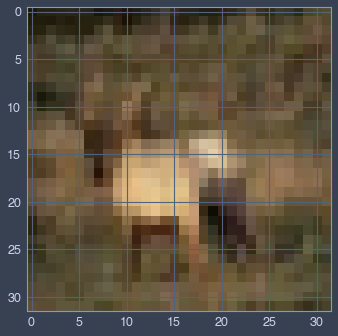

deer


In [169]:
imshow(sample_image, mean, std)
print(classes[sample_label])

In [164]:
print(type(trainset))
print(type(trainset[0][0]))
print(type(trainset[0][1]))

k = trainset[0][0].unsqueeze(dim=0)
k_p = [trainset[0][0]]
print(k.shape)

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torch.Tensor'>
<class 'int'>
torch.Size([1, 3, 32, 32])


## Coreset Methods

### Random Subset

In [15]:
# random subset implementation

### K-Center

In [16]:
# k-center implementation

## Gradient Matching

### $$\min_{S} \mathbb{E}_{\theta_0 \sim P_{\theta_0}} \left[\sum_{t=0}^{T-1} D\left(\nabla_{\theta} \mathcal{L}^S\left(\theta_t\right), \nabla_{\theta} \mathcal{L}^\mathcal{T}\left(\theta_t\right)\right)\right] $$

In [172]:
# dataset organization
images_all = [torch.unsqueeze(trainset[i][0], dim=0) for i in range(len(trainset))]
labels_all = [trainset[i][1] for i in range(len(trainset))]

indices_class = [[] for c in range(num_classes)]

for i, label in enumerate(labels_all):
    indices_class[label] = i

# these need to be sent to cuda if available
images_all = torch.cat(images_all, dim=0)
labels_all = torch.tensor(labels_all, dtype=torch.long)

print(type(images_all))
print(images_all.shape)
print(type(labels_all))
print(labels_all.shape)

def get_images(c, n): # randomly select n images from a class
    idx_shuffle = np.random.permutation(indices[c])[:n]
    return images_all[idx_shuffle]

<class 'torch.Tensor'>
torch.Size([50000, 3, 32, 32])
<class 'torch.Tensor'>
torch.Size([50000])


In [178]:
# synthetic dataset initialization (random noise)
ipc = 10 # images per class

# these need to be sent to cuda if available
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True)
label_syn = torch.tensor(np.array([np.ones(ipc)*i for i in range(num_classes)]), dtype=torch.long, requires_grad=False).view(-1)

print(image_syn.shape)
print(label_syn.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [187]:
# Network not my code; Taken from:
# https://github.com/VICO-UoE/DatasetCondensation

# customizable conv net
class ConvNet(nn.Module):
    def __init__(self, channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size=(32,32)):
        super(ConvNet, self).__init__()
        
        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_act, net_norm, net_pooling, im_size)
        num_feat = shape_feat[0]*shape_feat[1]*shape_feat[2]
        self.classifier = nn.Linear(num_feat, num_classes)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def embed(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        return out
    
    def _get_activation(self, net_act):
        if net_act == 'sigmoid':
            return nn.Sigmoid
        elif net_act == 'relu':
            return nn.ReLU(inplace=True)
        elif net_act == 'leakyrelu':
            return nn.LeakyReLU(negaitve_slope=0.01)
        else:
            exit('unknown activation function: %s'%net_act)
        
    def _get_pooling(self, net_pooling):
        if net_pooling == 'maxpooling':
            return nn.MaxPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            return nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            exit('unknown net_pooling: %s'%net_pooling)
            
    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            return nn.BatchNorm2d(shape_feat[0], affine=True)
        elif net_norm == 'layernorm':
            return nn.LayerNorm(shape_feat, elementwise_affine=True)
        elif net_norm == 'instancenorm':
            return nn.GroupNorm(shape_feat[0], shape_feat[0], affine=True)
        elif net_norm == 'groupnorm':
            return nn.GroupNorm(4, shape_feat[0], affine=True)
        elif net_norm == 'none':
            return None
        else:
            exit('unknown net_norm: %s'%net_norm)

    def _make_layers(self, channel, net_width, net_depth, net_act, net_norm, net_pooling, im_size):
        layers = []
        in_channels = channel
        shape_feat = [in_channels, im_size[0], im_size[1]]
        
        for i in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self._get_activation(net_act)]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self._get_pooling(net_pooling)]
                shape_feat[1] //= 2
                shape_feat[2] //= 2
                
        return nn.Sequential(*layers), shape_feat

In [188]:
# Network not my code; Taken from:
# https://github.com/VICO-UoE/DatasetCondensation

# mlp
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(32*32*3, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out - self.fc_3(out)
        return out

In [207]:
def epoch(mode, dataloader, net, optimizer, criterion):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    # send model to cuda if available
    # send criterion to cuda if available
    
    if mode == 'train':
        model.train()
    else:
        model.eval()

    for i_batch, datum in enumerate(dataloader):
        # send these to cuda if available
        img = datum[0].float()
        lab = datum[1].long()

        n_b = lab.shape[0]

        output = model(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b
        
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    loss_avg /= num_exp
    acc_avg /= num_exp
    
    return loss_avg, acc_avg

In [208]:
# training
optimizer_img = torch.optim.SGD([image_syn, ], lr=1.0, momentum=0.5)
optimizer_img.zero_grad()

# evaluation ckpts (every 2000)
num_evals = 20
iterations = 20000
eval_it_pool = np.arange(0, iterations+1, 2000).tolist()
# should have a model eval pool, but only evaluating with CNN and MLP for now just to test / learn training algorithm
# usually networks are selected from model eval pool
# ex: model_eval_pool = ['MLP', 'ConvNet']

# can import random models from networks.py later

In [209]:
class TensorDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.detach().float()
        self.labels = labels.detach()
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return self.images.shape[0]

In [218]:
datasave = []
accs_conv_net = [] # ordinarily a dict with keys for each model that's evaluated

for it in tqdm(range(iterations+1)):
    if it in eval_it_pool:
        # model iteration would go on this line
        accs = []
        for it_eval in range(num_evals):
            # this needs to be sent to cuda if available
            model = ConvNet(channel, num_classes, 128, 3, 'relu', 'instancenorm', 'avgpooling', im_size=(32,32))
#             image_syn_eval, label_syn_eval = copy.deepcopy(image_syn.detach(), copy.deepcopy(label_syn.detach()))
            
            # training on the synthetic dataset to find training / testing accuracy
            # these need to be sent to cuda if available
            # images_train
            # labels_train
            
            lr = 0.01
            epoch_eval_train = 1000
            lr_schedule = [epoch_eval_train // 2 + 1]
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
            
            # this needs to be sent to cuda if available
            criterion = nn.CrossEntropyLoss()
            
            # trianloader for synthetic dataset
            image_syn_eval, label_syn_eval = image_syn.detach().clone(), label_syn.detach().clone()
            syn_trainset = TensorDataset(image_syn_eval, label_syn_eval)
            syn_trainloader = torch.utils.data.DataLoader(syn_trainset, batch_size=256)
            testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)
            
            start = time.time()
            print('ya')
            for ep in tqdm(range(epoch_eval_train+1)):
                # DONT THESE GET OVERWRITTEN EACH TIME THE FUNCTION IS CALLED?
                loss_train, acc_train = epoch('train', syn_trainloader, model, optimizer, criterion)
                # reduce learning rate in the middle of training
                if ep in lr_schedule:
                    lr *= 0.1
                    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
            
            time_train = time.time() - start
            loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion)
            
            print('%s Evaluate_%02d: epoch = %04d train time = %d s train loss = %.6f train acc = %.4f, test acc = %.4f' % (get_time(), it_eval, epoch_eval_train, int(time_train), loss_train, acc_train, acc_test))

            accs.append(acc_test)

        print('Evaluate %d random %s, mean = %.4f std = %.4f\n-------------------------'%(len(accs), model_eval, np.mean(accs), np.std(accs)))
        
        if it == iterations:
            accs_conv_net += accs
            
        # save images of synthetic dataset at evaluation ckpts? would do it here
        save_name = os.path.join('./synthetic_images', 'vis_%s_%s_%s_%dipc_exp%d_iter%d.png'%('', 'CIFAR10', 'ConvNet', '10', '0', it))

SyntaxError: invalid syntax (<ipython-input-218-2e76b3822fdc>, line 55)

In [ ]:
# training & updating synthetic data


# Current SoTA

In [18]:
# current SoTA implementation